In [58]:
import json
import csv
from google.cloud import storage
from io import BytesIO
import pandas as pd
import numpy as np
import wordcloud
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
from collections import Counter
import os
import re
import string
from google.cloud import storage
import ndjson
import gzip
from urllib.request import urlopen
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize, pos_tag
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Load Data

In [2]:
#No need to run twice if you restart Kernel
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz

--2021-11-27 05:31:56--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 495854086 (473M) [application/x-gzip]
Saving to: ‘reviews_Electronics_5.json.gz.3’

reviews_Electronics 100%[===================>] 472.88M  3.21MB/s    in 2m 40s  

2021-11-27 05:34:37 (2.95 MB/s) - ‘reviews_Electronics_5.json.gz.3’ saved [495854086/495854086]



In [3]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Electronics.json.gz

--2021-11-27 05:34:43--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Electronics.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1198601797 (1.1G) [application/octet-stream]
Saving to: ‘meta_Electronics.json.gz.2’

meta_Electronics.js 100%[===================>]   1.12G  41.9MB/s    in 28s     

2021-11-27 05:35:12 (40.8 MB/s) - ‘meta_Electronics.json.gz.2’ saved [1198601797/1198601797]



In [2]:
data = []
with gzip.open('reviews_Electronics_5.json.gz') as f:
    for i in f:
        data.append(json.loads(i.strip()))

In [3]:
len(data)

1689188

In [4]:
client = storage.Client()
bucket_name = "lhuang335"
file_name = "1_community_nodes_final.csv"
bucket = client.get_bucket(bucket_name)
blob = bucket.get_blob(file_name)
content = blob.download_as_string()
df = pd.read_csv(BytesIO(content))
df.head()

,Id,Label,timeset,modularity_class
0,B008ZYLFNO,Amzer AMZ94665 Soft Silicone Jelly Skin Fit Ca...,NaN,9
1,B01BTDAFTC,Samsung Galaxy TabPro S 12&quot; Screen Protec...,NaN,13
2,B00VDW7KM0,Generic Compatible Replacement AC Adapter Char...,NaN,10
3,B009STIJWA,PWR+ UL Listed 10W Extra Long 6.5 Ft Samsung G...,NaN,15
4,B013S9F7AW,Mr Shield for Samsung Galaxy Tab A 8.0 Inch Pr...,NaN,18


## Clean data

In [5]:
def clean_data(data):
    #combine reviews
    review = []
    for i in range(len(data)):
        if 'reviewText' in data[i]:
            review.append(data[i]['reviewText'])
        elif 'summary' in data[i]:
            review.append(data[i]['summary'])  
            
    review = ' '.join(review)
    
    #remove stop words
    new_tokens = word_tokenize(review)
    new_tokens = [r.lower() for r in new_tokens]
    new_tokens = [r for r in new_tokens if r not in stopwords.words('english')]
    
    #lemmatize words
    lemmatizer = WordNetLemmatizer()
    new_tokens = [lemmatizer.lemmatize(t) for t in new_tokens]
    
    #remove punctuation
    new_tokens = [words for words in new_tokens if words not in string.punctuation]  
    
    #remove numbers
    new_tokens = [words for words in new_tokens if not words.isdigit()]
    
    #remove other punctuation/words
    new_tokens = [words for words in new_tokens if words not in ['...','``',"''",'would',"'s","n't","--",'also',"'m","'ve"]]
    
    
    return new_tokens #output -> list


In [6]:
def count_words(words_list,number_top_words):
    counter = Counter(words_list)
    frequent = counter.most_common(number_top_words)
    
    return frequent

## Explore by asin number

In [7]:
Asin  =  []
for i in range(len(data)):
    Asin.append(data[i]['asin'])

In [8]:
unique_asin = set(Asin)

In [9]:
asin_dict = {}
for i in Asin:
    asin_dict[i] = asin_dict.get(i,0) +1

In [10]:
community_node = df.Id.to_list()

In [11]:
asin_community_dict = {}

In [12]:
#not all asin numers in 1st community sits in 5-core review
for k,v in asin_dict.items():
    if k in community_node:
        asin_community_dict[k] = v

In [13]:
#sort top reviewed products
asin_community_dict = dict(sorted(asin_community_dict.items(),key = lambda x:x[1], reverse = True))

In [14]:
#top_20 = sorted(asin_dict, key=asin_dict.get, reverse=True)[:20]
words_bag = {}
for i in asin_community_dict:
    words_bag[i] = clean_data([review for review in data if review['asin']==i])
    print('finished',i)

finished B007P4VOWC
finished B00D02AG7C
finished B00F3SOHNU
finished B00D02AHEO
finished B004CGHDEO
finished B00BQH8UEY
finished B004XZL980
finished B00D029NNA
finished B00BP5MB56
finished B004DBD4TG
finished B00CGVF8E4
finished B007TYUUPK
finished B005518J6Q
finished B00E4B1TW4
finished B00HWMPRKW
finished B009STIJWA
finished B008D9DVVK
finished B00DNVA184
finished B00G02YZ2Q
finished B00947LCZW
finished B0055193D4
finished B0083XTPH0
finished B005593W10
finished B005TJPFBG
finished B007JWUP52
finished B009ZQKMDA
finished B006MAWKRI
finished B0055OW68U
finished B00ESYW40S
finished B00A6SZWHC
finished B00F1CRTJM
finished B00HWMPRKC
finished B00DLZWCV6
finished B004VPLY1E
finished B00I3ERXWS
finished B00F3U2H80
finished B00IIHNVF8
finished B00KHA5G6G
finished B0051D3KMG
finished B005EJLFXI
finished B005EMR2EG
finished B00JKCH4X0
finished B00KHA2DQM
finished B0096KJTU2
finished B00BV9TY8I
finished B007Y3FYWU
finished B00906HOEK
finished B009ZN8TEM
finished B00BF9I1DS
finished B00DMWFS8C


In [42]:
#count result:
words_bag_count = {}
for i in asin_community_dict:
    words_bag_count[i] = count_words(clean_data([review for review in data if review['asin']==i]),5)
    print('finished',i)

finished B007P4VOWC
finished B00D02AG7C
finished B00F3SOHNU
finished B00D02AHEO
finished B004CGHDEO
finished B00BQH8UEY
finished B004XZL980
finished B00D029NNA
finished B00BP5MB56
finished B004DBD4TG
finished B00CGVF8E4
finished B007TYUUPK
finished B005518J6Q
finished B00E4B1TW4
finished B00HWMPRKW
finished B009STIJWA
finished B008D9DVVK
finished B00DNVA184
finished B00G02YZ2Q
finished B00947LCZW
finished B0055193D4
finished B0083XTPH0
finished B005593W10
finished B005TJPFBG
finished B007JWUP52
finished B009ZQKMDA
finished B006MAWKRI
finished B0055OW68U
finished B00ESYW40S
finished B00A6SZWHC
finished B00F1CRTJM
finished B00HWMPRKC
finished B00DLZWCV6
finished B004VPLY1E
finished B00I3ERXWS
finished B00F3U2H80
finished B00IIHNVF8
finished B00KHA5G6G
finished B0051D3KMG
finished B005EJLFXI
finished B005EMR2EG
finished B00JKCH4X0
finished B00KHA2DQM
finished B0096KJTU2
finished B00BV9TY8I
finished B007Y3FYWU
finished B00906HOEK
finished B009ZN8TEM
finished B00BF9I1DS
finished B00DMWFS8C


Takes the top ***n*** products by the number of reviews. Compiles all the reviews for each product and returns a list of the top  ***m*** words along with the number of times they appear.  

*n* = 20

*m* = 25

These numbers can (and should) be increased for final computation

## write out data file

In [43]:
l = [(k,*t) for k,v in words_bag_count.items() for t in v]
df = pd.DataFrame(l,columns = ['asin','key_word','count'])

In [44]:
display(df.head(50))

,asin,key_word,count
0,B007P4VOWC,tablet,1407
1,B007P4VOWC,samsung,613
2,B007P4VOWC,use,579
3,B007P4VOWC,tab,513
4,B007P4VOWC,device,482
5,B00D02AG7C,tablet,352
6,B00D02AG7C,samsung,169
7,B00D02AG7C,tab,163
8,B00D02AG7C,great,128
9,B00D02AG7C,like,127


In [45]:
df.to_csv('community1_words_count.csv')
!gsutil cp 'community1_words_count.csv' 'gs://lhuang335/'

Copying file://community1_words_count.csv [Content-Type=text/csv]...
/ [1 files][  8.2 KiB/  8.2 KiB]                                                
Operation completed over 1 objects/8.2 KiB.                                      


## Word Cloud

Specifically designed for word cloud package

In [19]:
for i in top_20:
    if data['asin']==i:
        
no1 = " ".join(i for i in clean_data(data))

IndentationError: expected an indented block (<ipython-input-19-734b2d158b9c>, line 4)

In [54]:
test1

NameError: name 'test1' is not defined

In [55]:
def make_word_cloud(text_or_counter, stop_words=None):
    if isinstance(text_or_counter, str):
        word_cloud = wordcloud.WordCloud(stopwords=stop_words,max_font_size=50, max_words=100, background_color="white").generate(text_or_counter)
    else:
        if stop_words is not None:
            text_or_counter = Counter(word for word in text_or_counter if word not in stop_words)
        word_cloud = wordcloud.WordCloud(stopwords=stop_words).generate_from_frequencies(text_or_counter)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [56]:
test = clean_data(data[:2])

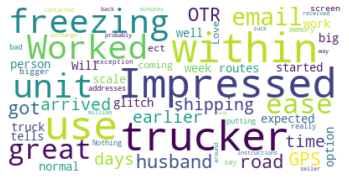

In [58]:
make_word_cloud(data[0]['reviewText'], stop_words=None)

## Find Topics (Latent Dirichlet Allocation)

In [48]:
def find_topics(text, number_topics, number_words): #input should be from clean_data() 
    text = ' '.join(text)
    count_vectorizer = CountVectorizer(stop_words = 'english')
    count_data = count_vectorizer.fit_transform([text])
    lda = LDA(n_components=number_topics, n_jobs = -1)
    lda.fit(count_data)
    
    words = count_vectorizer.get_feature_names()
    
    topics = [[words[i] for i in topic.argsort()[:-number_words -1:-1]] for (topic_idx, topic) in enumerate(lda.components_)]
    topics = np.array(topics).ravel()
    
    #existing_topics = set.intersection(set(topics), unique_tags)
    
    return topics

In [50]:
find_topics(words_bag['B00D02AHEO'], 3, 10)

array(['carrier', 'placing', 'droid48', 'hellooooow', 'held',
       'characteristic', 'pile', 'pinching', 'character', 'pixels',
       'carrier', 'placing', 'droid48', 'hellooooow', 'held',
       'characteristic', 'pile', 'pinching', 'character', 'pixels',
       'tablet', 'tab', 'screen', 'samsung', 'galaxy', 'use', 'like',
       'device', 'size', 'android'], dtype='<U14')

In [59]:
id2word = corpora.Dictionary(words_bag['B00D02AHEO'])

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [ ]:



lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [45]:
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    #tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(text) if is_noun(pos)]
    return ' '.join(all_nouns)

In [46]:
nouns(words_bag['B00D02AHEO'])

"tab tab time improvement product lot ipads ipads itunes fact apple observation number pay apps work speed tablet program picture product buyer fact android fan samsung samsung google stuff strip tablet spends time app entertainment system end work love samsung tablet size search thing price tablet size thing work withoutlag keyboard apps core game tab tablet note note day day life use lightweight year market connects chromecast combination lot option tablet.id star look reason star interface see apps google galaxy issueits feel anyone thing ir sensor star tv day screen sec time day design flaw kindle fire quick fast othdrs proclaim reading presentation note picture name buy notch love fun size tv galaxy cost samsung note love product size tablet upgrade size tablet carry set use display work use use replacement email internet tablet google nexus wife tab samsung job interface course kid use tablet edition galaxy tab grip c feature interface parent control apps hour day device.amazon s

In [69]:
full_text_list = []
for i,v in words_bag.items():
    full_text_list.append(' '.join(v))
full_text = " ".join(v for i,v in words_bag.items())

TypeError: sequence item 0: expected str instance, list found

In [ ]:
for i,v in words_bag.items():
    print(v)

In [41]:
find_topics(words_bag['B00D02AHEO'],1,5)

array(['tablet', 'tab', 'screen', 'samsung', 'galaxy'], dtype='<U7')

In [18]:
for i in words_bag:
    print(i)

B007P4VOWC
B00D02AG7C
B00F3SOHNU
B00D02AHEO
B004CGHDEO
B00BQH8UEY
B004XZL980
B00D029NNA
B00BP5MB56
B004DBD4TG
B00CGVF8E4
B007TYUUPK
B005518J6Q
B00E4B1TW4
B00HWMPRKW
B009STIJWA
B008D9DVVK
B00DNVA184
B00G02YZ2Q
B00947LCZW
B0055193D4
B0083XTPH0
B005593W10
B005TJPFBG
B007JWUP52
B009ZQKMDA
B006MAWKRI
B0055OW68U
B00ESYW40S
B00A6SZWHC
B00F1CRTJM
B00HWMPRKC
B00DLZWCV6
B004VPLY1E
B00I3ERXWS
B00F3U2H80
B00IIHNVF8
B00KHA5G6G
B0051D3KMG
B005EJLFXI
B005EMR2EG
B00JKCH4X0
B00KHA2DQM
B0096KJTU2
B00BV9TY8I
B007Y3FYWU
B00906HOEK
B009ZN8TEM
B00BF9I1DS
B00DMWFS8C
B00ESYW4G2
B00HL3P9EG
B00E4HF2TY
B00ENZE05Y
B00JZM7T2Q
B007ZZAMAQ
B00JRULWM4
B0061OVOQI
B00C5WXHXI
B00CA7UF1A
B00HQ08QP8
B00HWJZF9I
B00H3DJAWG
B00IWJM9SW
B007BV1Y7E
B00JM6L0PW
9876050621
B0048A0JLS
B00C2APTO8
B00FGOAA7I
B00IQWSP1A


{'B007P4VOWC': ['really',
  'good',
  'tab',
  'lot',
  'uses.one',
  'big',
  'thing',
  'helped',
  'lot',
  'travel',
  'thanks',
  'gps',
  'search',
  'get',
  'point',
  'point',
  'b',
  'pre-load',
  'map',
  'help',
  'get',
  'destination.as',
  'put',
  'information',
  'get',
  'bit',
  'slow.also',
  'touch',
  'sensitive',
  'tried',
  'several',
  'tablet',
  'settled',
  'one',
  'samsung',
  'make',
  'good',
  'tablet',
  'medium',
  'price',
  'range',
  'easy',
  'use.as',
  'year',
  'old',
  'grannie',
  'sure',
  'holiday',
  'found',
  'good',
  'photo',
  'video',
  'bought',
  'original',
  'retail',
  'price',
  'bb',
  'say',
  'best',
  'tablet',
  'ever',
  'owned',
  'everything',
  'want',
  'love',
  'microsd',
  'slot',
  'music',
  'gps',
  'work',
  'great',
  'jellybean',
  'rolled',
  'month',
  'ago',
  'work',
  'even',
  'better',
  'say',
  'tad',
  'limited',
  'memory',
  'since',
  'jellybean',
  'hog',
  'resource',
  'quite',
  'bit',
  'd